In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util as len_plot_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.lenses import lens_util
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [2]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')  # _parallelized
r = np.load(os.path.join(ps_dir, 'r.npy'))

In [3]:
files = glob(f'{ps_dir}/im_subs_no_subhalos_*.npy')
uids = [int(f.split('_')[-1].split('.')[0]) for f in files]

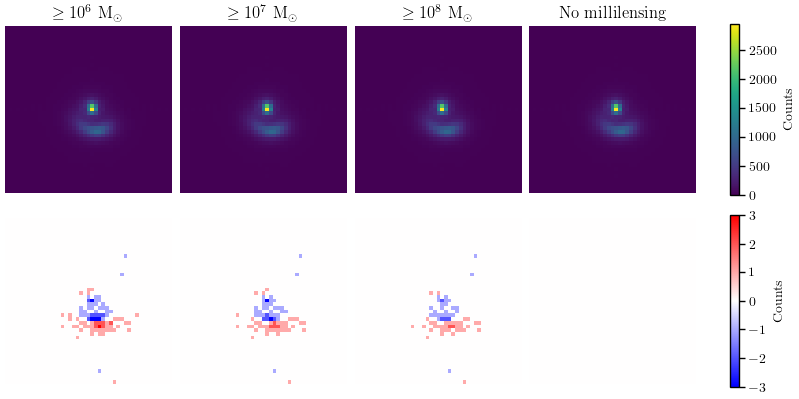

In [4]:
id = np.random.choice(uids)
uid = str(id).zfill(8)

images = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'im_subs_*_{uid}.npy')))]
# kappa_images = [np.load(i) for i in glob(os.path.join(ps_dir, 'kappa_im_*.npy'))]

r = np.load(os.path.join(ps_dir, 'r.npy'))
# kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))

f, ax = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

res_array = [images[3] - images[i] for i in range(4)]
v = plot_util.get_v(res_array)

for i in range(4):
    axis = ax[0][i].imshow(images[i])
    ax[0][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[0])
cbar.set_label('Counts', rotation=90)

for i in range(4):
    axis = ax[1][i].imshow(images[3] - images[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('Counts', rotation=90)

ax[0][0].set_title('$\geq 10^6$ M$_\odot$')
ax[0][1].set_title('$\geq 10^7$ M$_\odot$')
ax[0][2].set_title('$\geq 10^8$ M$_\odot$')
ax[0][3].set_title('No millilensing')

plt.savefig(os.path.join(repo_dir, 'figures', 'residuals_subhalo_pops.png'))
plt.show()

['/data/scratch/btwedig/mejiro/output/power_spectra_parallelized/im_det_17_00000506.npy',
 '/data/scratch/btwedig/mejiro/output/power_spectra_parallelized/im_det_1_00000506.npy',
 '/data/scratch/btwedig/mejiro/output/power_spectra_parallelized/im_det_4_00000506.npy',
 '/data/scratch/btwedig/mejiro/output/power_spectra_parallelized/im_det_9_00000506.npy']


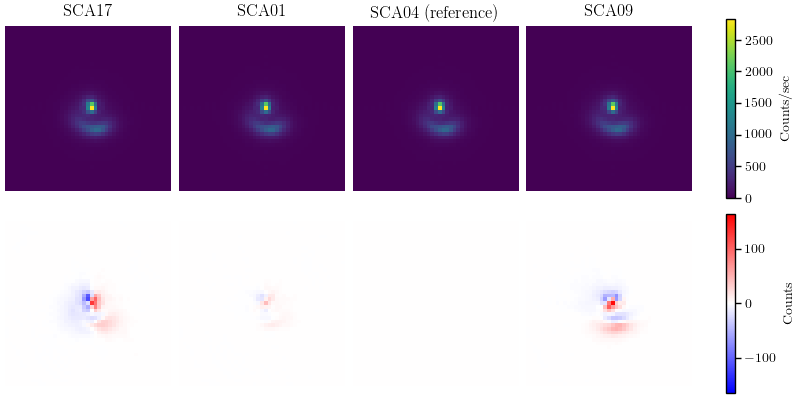

In [5]:
images = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'im_det_*_{uid}.npy')))]
# kappa_images = [np.load(i) for i in glob(os.path.join(ps_dir, 'kappa_im_*.npy'))]
pprint(sorted(glob(os.path.join(ps_dir, f'im_det_*_{uid}.npy'))))

r = np.load(os.path.join(ps_dir, 'r.npy'))
# kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))

f, ax = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

res_array = [images[3] - images[i] for i in range(4)]
v = plot_util.get_v(res_array)

for i in range(4):
    axis = ax[0][i].imshow(images[i])
    ax[0][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[0])
cbar.set_label('Counts/sec', rotation=90)

for i in range(4):
    axis = ax[1][i].imshow(images[2] - images[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('Counts', rotation=90)

ax[0][0].set_title('SCA17')
ax[0][1].set_title('SCA01')
ax[0][2].set_title('SCA04 (reference)')
ax[0][3].set_title('SCA09')

plt.savefig(os.path.join(repo_dir, 'figures', 'residuals_PSF_pos.png'))
plt.show()

In [6]:
limit = 1000

power_list_no_subhalos = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_no_subhalos_*.npy')))][:limit]
power_list_cut_6 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_6_*.npy')))][:limit]
power_list_cut_7 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_7_*.npy')))][:limit]
power_list_cut_8 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_8_*.npy')))][:limit]

stack_no_subhalos = np.vstack(power_list_no_subhalos)
stack_list_cut_6 = np.vstack(power_list_cut_6)
stack_list_cut_7 = np.vstack(power_list_cut_7)
stack_list_cut_8 = np.vstack(power_list_cut_8)

In [7]:
# power_list_no_subhalos_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_no_subhalos.npy'))]
# power_list_cut_6_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_6.npy'))]
# power_list_cut_7_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_7.npy'))]
# power_list_cut_8_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_8.npy'))]

# stack_no_subhalos_kappa = np.vstack(power_list_no_subhalos_kappa)
# stack_list_cut_6_kappa = np.vstack(power_list_cut_6_kappa)
# stack_list_cut_7_kappa = np.vstack(power_list_cut_7_kappa)
# stack_list_cut_8_kappa = np.vstack(power_list_cut_8_kappa)

In [8]:
# plt.plot(r, np.mean(stack_list_cut_8, axis=0), label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_7, axis=0), label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_6, axis=0), label='$\geq 10^6$ M$_\odot$')
# plt.plot(r, np.mean(stack_no_subhalos, axis=0), label='No subhalos')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [9]:
res_8 = np.mean(stack_list_cut_8, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_7 = np.mean(stack_list_cut_7, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_6 = np.mean(stack_list_cut_6, axis=0) - np.mean(stack_no_subhalos, axis=0)

# TODO fix
std_8 = np.std(stack_list_cut_8 - stack_no_subhalos, axis=0, ddof=1)
std_7 = np.std(stack_list_cut_7 - stack_no_subhalos, axis=0, ddof=1)
std_6 = np.std(stack_list_cut_6 - stack_no_subhalos, axis=0, ddof=1)

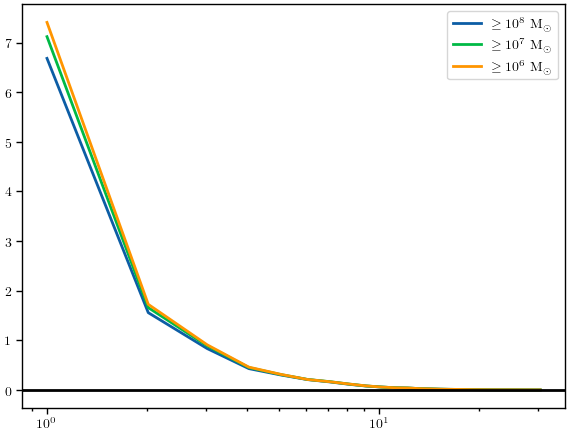

In [10]:
plt.plot(r, res_8, label='$\geq 10^8$ M$_\odot$')
# plt.fill_between(r, res_8 - std_8, res_8 + std_8, alpha=0.2)
plt.plot(r, res_7, label='$\geq 10^7$ M$_\odot$')
# plt.fill_between(r, res_7 - std_7, res_7 + std_7, alpha=0.2)
plt.plot(r, res_6, label='$\geq 10^6$ M$_\odot$')
# plt.fill_between(r, res_6 - std_6, res_6 + std_6, alpha=0.2)
# plt.plot(r, np.median(stack_list_cut_8 - stack_no_subhalos), axis=1)
plt.axhline(0, color='black')

# for i in range(2):
#     plt.plot(r, percentile_8[i], color='b', linestyle=':')
#     plt.plot(r, percentile_7[i], color='g', linestyle=':')
#     plt.plot(r, percentile_6[i], color='orange', linestyle=':')

plt.xscale('log')
plt.legend()
plt.show()

In [11]:
# res_8_kappa = np.mean(stack_list_cut_8_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_7_kappa = np.mean(stack_list_cut_7_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_6_kappa = np.mean(stack_list_cut_6_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)

In [12]:
# plt.plot(r, res_8_kappa, label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, res_6_kappa, label='$\geq 10^6$ M$_\odot$')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [13]:
power_list_nominal = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_4_*.npy')))][:limit]
power_list_1 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_1_*.npy')))][:limit]
power_list_9 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_9_*.npy')))][:limit]
power_list_17 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_17_*.npy')))][:limit]
power_list_gaussian = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_gaussian_psf_*.npy')))][:limit]

stack_nominal = np.vstack(power_list_nominal)
stack_list_1 = np.vstack(power_list_1)
stack_list_9 = np.vstack(power_list_9)
stack_list_17 = np.vstack(power_list_17)
stack_list_gaussian = np.vstack(power_list_gaussian)

In [14]:
# for ps in power_list_nominal:
#     plt.loglog(r, ps, color='black', alpha=0.1)
# for ps in power_list_1:
#     plt.loglog(r, ps, color='blue', alpha=0.1)
# for ps in power_list_9:
#     plt.loglog(r, ps, color='red', alpha=0.1)
# for ps in power_list_17:
#     plt.loglog(r, ps, color='green', alpha=0.1)
# for ps in power_list_gaussian:
#     plt.loglog(r, ps, color='orange', alpha=0.1)
# plt.show()

In [15]:
dif_1 = np.mean(stack_list_1, axis=0) - np.mean(stack_nominal, axis=0)
dif_9 = np.mean(stack_list_9, axis=0) - np.mean(stack_nominal, axis=0)
dif_17 = np.mean(stack_list_17, axis=0) - np.mean(stack_nominal, axis=0)
dif_gaus = np.mean(stack_list_gaussian, axis=0) - np.mean(stack_nominal, axis=0)

std_1 = np.std(stack_list_1 - stack_nominal, axis=0, ddof=1)
std_9 = np.std(stack_list_9 - stack_nominal, axis=0, ddof=1)
std_17 = np.std(stack_list_17 - stack_nominal, axis=0, ddof=1)

In [16]:
# plt.plot(r, dif_1, label='Middle: SCA01')
# plt.plot(r, dif_9, label='Far left: SCA09')
# plt.plot(r, dif_17, label='Far right: SCA17')
# # plt.plot(r, dif_gaus, label='Gaussian PSF')
# plt.axhline(0, color='black', linestyle='--', alpha=0.5)
# plt.xscale('log')
# plt.legend()
# plt.show()

In [17]:
np.save(os.path.join(ps_dir, 'res_6'), res_6)
np.save(os.path.join(ps_dir, 'res_7'), res_7)
np.save(os.path.join(ps_dir, 'res_8'), res_8)
np.save(os.path.join(ps_dir, 'r.npy'), r)

In [18]:
res_6 = np.load(os.path.join(ps_dir, 'res_6.npy'))
res_7 = np.load(os.path.join(ps_dir, 'res_7.npy'))
res_8 = np.load(os.path.join(ps_dir, 'res_8.npy'))

In [19]:
cut_8_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_8.pkl')
cut_7_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_7.pkl')
cut_6_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_6.pkl')

In [20]:
# get average number of subhalos
num_subhalos = []
for realization in cut_6_realizations:
    num_subhalos.append(len(realization.halos))
avg = np.mean(num_subhalos)
print(f'Average number of subhalos: {round(avg)}')
print(f'Square root: {round(np.sqrt(avg))}')

Average number of subhalos: 403
Square root: 20


[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08 1.66810054e+08 2.78255940e+08
 4.64158883e+08 7.74263683e+08 1.29154967e+09 2.15443469e+09
 3.59381366e+09 5.99484250e+09]
[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08 1.66810054e+08 2.78255940e+08
 4.64158883e+08 7.74263683e+08 1.29154967e+09 2.15443469e+09
 3.59381366e+09 5.99484250e+09 1.00000000e+10]
(18,)
(18,)


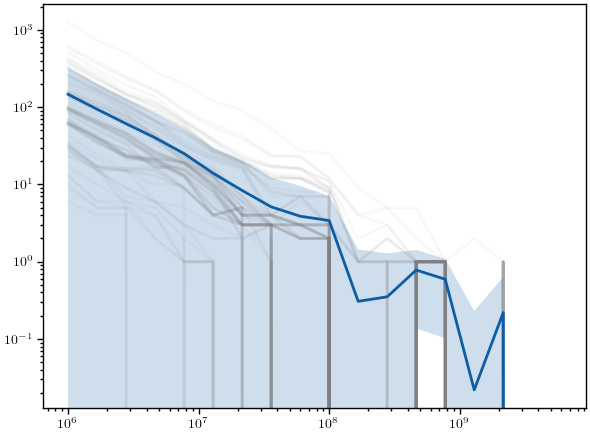

In [21]:
cut_6_list = []
for realization in cut_6_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 19))
    cut_6_list.append(N)
    plt.loglog(m[:-1], N, alpha=0.05, color='grey')

print(m[:-1])
print(np.logspace(6, 10, 19))

m_mean = np.mean(cut_6_list, axis=0)
print(m_mean.shape)

m_stdev = np.std(cut_6_list, axis=0)
print(m_stdev.shape)

plt.loglog(m[:-1], m_mean)
plt.fill_between(m[:-1], m_mean - m_stdev, m_mean + m_stdev, alpha=0.2)
plt.show()

In [22]:
# caculations for ax[0][0]

def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        cdm_halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins_6, mean_6, std_6 = get_bins_mean_std(cut_6_realizations, 20)
bins_7, mean_7, std_7 = get_bins_mean_std(cut_7_realizations, 20)
bins_8, mean_8, std_8 = get_bins_mean_std(cut_8_realizations, 20)

In [23]:
# calculations for 
assert len(power_list_nominal) == len(power_list_1) == len(power_list_9) == len(power_list_17)

residual_ps_1, residual_ps_9, residual_ps_17 = [], [], []
for i, _ in enumerate(power_list_nominal):
    residual_1 = [cut - none for cut, none in zip(power_list_1[i], power_list_nominal[i])]
    residual_9 = [cut - none for cut, none in zip(power_list_9[i], power_list_nominal[i])]
    residual_17 = [cut - none for cut, none in zip(power_list_17[i], power_list_nominal[i])]

    residual_ps_1.append(residual_1)
    residual_ps_9.append(residual_9)
    residual_ps_17.append(residual_17)

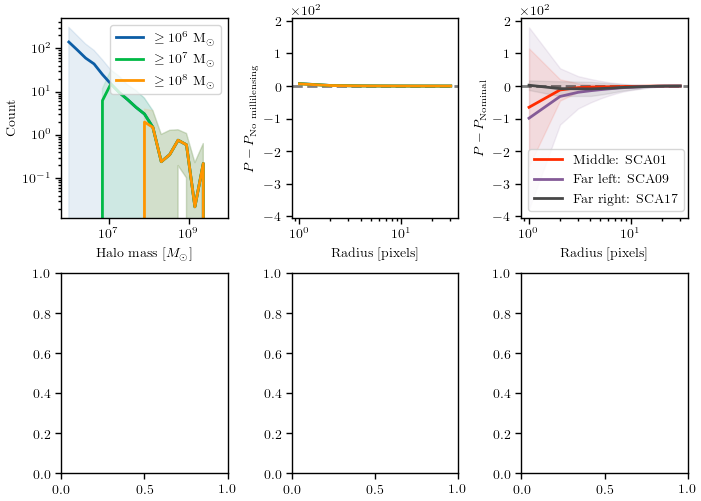

In [24]:
f, ax = plt.subplots(2, 3, figsize=(7, 5), constrained_layout=True)

ax[0][0].loglog(bins_6, mean_6, alpha=1., color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
ax[0][0].fill_between(bins_6, mean_6 - std_6, mean_6 + std_6, alpha=0.1, color='#0C5DA5')
ax[0][0].loglog(bins_7, mean_7, alpha=1., color='#00B945', label='$\geq 10^7$ M$_\odot$')
ax[0][0].fill_between(bins_7, mean_7 - std_7, mean_7 + std_7, alpha=0.1, color='#00B945')
ax[0][0].loglog(bins_8, mean_8, alpha=1., color='#FF9500', label='$\geq 10^8$ M$_\odot$')
ax[0][0].fill_between(bins_8, mean_8 - std_8, mean_8 + std_8, alpha=0.1, color='#FF9500')
ax[0][0].set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax[0][0].set_ylabel('Count')
ax[0][0].legend()

ax[0][1].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i in range(limit):  #  + np.random.randint(0, 90)
#     ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='#FF9500')
ax[0][1].plot(r, res_6, color='#0C5DA5')
ax[0][1].plot(r, res_7, color='#00B945')
ax[0][1].plot(r, res_8, color='#FF9500')
ax[0][1].sharey(ax[0][2])
# ax[0][1].set_ylim([-6e-3, 6e-3])
ax[0][1].set_xscale('log')
ax[0][1].set_xlabel('Radius [pixels]')
ax[0][1].set_ylabel(r'$P - P_{\textrm{No millilensing}}$')

# x1, x2, y1, y2 = 0.95, 1.3, 8e-4, 1.15e-3
# zoom_axes = ax[0][1].inset_axes(bounds=[0.6,0.05,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # 
# for i in range(limit):
#     zoom_axes.plot(r, res_6, color='#0C5DA5')
#     zoom_axes.plot(r, res_7, color='#00B945')
#     zoom_axes.plot(r, res_8, color='#FF9500')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
# zoom_axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

limit = 15
ax[0][2].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i, _ in enumerate(power_list_nominal):
#     ax[0][2].plot(r, residual_ps_1[i], alpha=0.1, color='#FF2C00')
#     ax[0][2].plot(r, residual_ps_9[i], alpha=0.1, color='#845B97')
#     ax[0][2].plot(r, residual_ps_17[i], alpha=0.1, color='#474747')
ax[0][2].plot(r, dif_1, color='#FF2C00', label='Middle: SCA01')
ax[0][2].plot(r, dif_9, color='#845B97', label='Far left: SCA09')
ax[0][2].plot(r, dif_17, color='#474747', label='Far right: SCA17')

ax[0][2].fill_between(r, dif_1 - std_1, dif_1 + std_1, alpha=0.1, color='#FF2C00')
ax[0][2].fill_between(r, dif_9 - std_9, dif_9 + std_9, alpha=0.1, color='#845B97')
ax[0][2].fill_between(r, dif_17 - std_17, dif_17 + std_17, alpha=0.1, color='#474747')


ax[0][2].set_xscale('log')
ax[0][2].set_xlabel('Radius [pixels]')
ax[0][2].set_ylabel(r'$P - P_{\textrm{Nominal}}$')
ax[0][2].legend()
ax[0][2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()

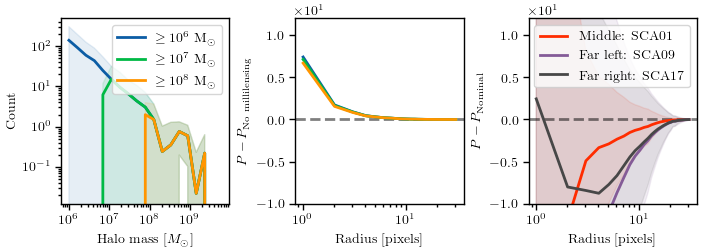

In [25]:
f, ax = plt.subplots(1, 3, figsize=(7, 2.5), constrained_layout=True)

ax[0].loglog(bins_6, mean_6, alpha=1., color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
ax[0].fill_between(bins_6, mean_6 - std_6, mean_6 + std_6, alpha=0.1, color='#0C5DA5')
ax[0].loglog(bins_7, mean_7, alpha=1., color='#00B945', label='$\geq 10^7$ M$_\odot$')
ax[0].fill_between(bins_7, mean_7 - std_7, mean_7 + std_7, alpha=0.1, color='#00B945')
ax[0].loglog(bins_8, mean_8, alpha=1., color='#FF9500', label='$\geq 10^8$ M$_\odot$')
ax[0].fill_between(bins_8, mean_8 - std_8, mean_8 + std_8, alpha=0.1, color='#FF9500')
ax[0].set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax[0].set_ylabel('Count')
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i in range(limit):  #  + np.random.randint(0, 90)
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='#FF9500')
ax[1].plot(r, res_6, color='#0C5DA5')
ax[1].plot(r, res_7, color='#00B945')
ax[1].plot(r, res_8, color='#FF9500')
ax[1].sharey(ax[2])
ax[1].set_ylim([-10, 12])
ax[1].set_xscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'$P - P_{\textrm{No millilensing}}$')

# x1, x2, y1, y2 = 0.95, 1.3, 8e-4, 1.15e-3
# zoom_axes = ax[1].inset_axes(bounds=[0.6,0.05,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # 
# for i in range(limit):
#     zoom_axes.plot(r, res_6, color='#0C5DA5')
#     zoom_axes.plot(r, res_7, color='#00B945')
#     zoom_axes.plot(r, res_8, color='#FF9500')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
# zoom_axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

limit = 15
ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i, _ in enumerate(power_list_nominal):
#     ax[2].plot(r, residual_ps_1[i], alpha=0.1, color='#FF2C00')
#     ax[2].plot(r, residual_ps_9[i], alpha=0.1, color='#845B97')
#     ax[2].plot(r, residual_ps_17[i], alpha=0.1, color='#474747')
ax[2].plot(r, dif_1, color='#FF2C00', label='Middle: SCA01')
ax[2].plot(r, dif_9, color='#845B97', label='Far left: SCA09')
ax[2].plot(r, dif_17, color='#474747', label='Far right: SCA17')

ax[2].fill_between(r, dif_1 - std_1, dif_1 + std_1, alpha=0.1, color='#FF2C00')
ax[2].fill_between(r, dif_9 - std_9, dif_9 + std_9, alpha=0.1, color='#845B97')
ax[2].fill_between(r, dif_17 - std_17, dif_17 + std_17, alpha=0.1, color='#474747')


ax[2].set_xscale('log')
ax[2].set_xlabel('Radius [pixels]')
ax[2].set_ylabel(r'$P - P_{\textrm{Nominal}}$')
ax[2].legend()
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()

In [26]:
# custom_lines_1 = [Line2D([0], [0], color='#0C5DA5'),
#                 Line2D([0], [0], color='#00B945'),
#                 Line2D([0], [0], color='#FF9500')]

# ax[0][0].legend(custom_lines_1, ['$\geq 10^6$ M$_\odot$', '$\geq 10^7$ M$_\odot$', '$\geq 10^8$ M$_\odot$'])

# custom_lines_2 = [Line2D([0], [0], color='#FF2C00'),
#                 Line2D([0], [0], color='#845B97'),
#                 Line2D([0], [0], color='#474747')]

# ax[0][2].legend(custom_lines_2, ['Middle: SCA01', 'Far left: SCA09', 'Far right: SCA17'])

In [27]:
# # TODO ax[0][0] show a nice color image of a strong lens with caustics etc. overplotted, with a legend
# ax[0][0].imshow(np.log10(with_subhalos), cmap='binary')
# ax[0][0].set_aspect('equal')
# overplot.source_position(ax[0][0], lens, coords, linewidth=2, alpha=0.6, color='black')
# overplot.lens_position(ax[0][0], lens, coords, linewidth=2, alpha=0.6, color='red')
# overplot.caustics(ax[0][0], lens, coords, num_pix, delta_pixg=0.11, linewidth=2, alpha=0.6, color='g')
# overplot.critical_curves(ax[0][0], lens, coords, num_pix, delta_pix=0.11, linewidth=2, alpha=0.6, color='b')
# len_plot_util.scale_bar(ax[0][0], d=with_subhalos.shape[0], dist=1 / 0.11, text='1"', color='black', flipped=True)
# ax[0][0].legend()

# # TODO ax[0][1] show subhalos overplotted
# ax[0][1].imshow(np.log10(with_subhalos), cmap='binary')

# # overplot subhalos
# coords = lens_util.get_coords(45, delta_pix=0.11)
# for halo in realization.halos:
#     if halo.mass > 1e8:
#         ax[0][1].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='#FF9500')
#     elif halo.mass > 1e7:
#         ax[0][1].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='#00B945')
#     else:
#         ax[0][1].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='#0C5DA5')

# # TODO ax[0][2] individual power spectra showing middle, far left, far right, and even Gaussian PSF? also band-dependence, so F106, F129, F184
# ax[0][2].imshow(np.log10(with_subhalos), cmap='binary')

In [28]:
# f, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)  # , sharey=True

# limit = 15

# cut_6_list = []
# for realization in cut_6_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_6_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
# cut_7_list = []
# for realization in cut_7_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_7_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#00B945', label='$\geq 10^7$ M$_\odot$')
# cut_8_list = []
# for realization in cut_8_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_8_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#FF9500', label='$\geq 10^8$ M$_\odot$')

# m_mean = np.mean(cut_6_list, axis=0)
# ax[0].loglog(m[0:-1], m_mean, color='black', linestyle='--', linewidth=3)

# ax[0].set_xlabel('Halo mass '+r'$M_{\odot}$')
# ax[0].set_ylabel('n(M)')
# ax[0].set_title('Subhalo mass functions')

# from matplotlib.lines import Line2D
# custom_lines_1 = [Line2D([0], [0], color='#0C5DA5'),
#                 Line2D([0], [0], color='#00B945'),
#                 Line2D([0], [0], color='#FF9500')]

# # ax.plot(r, flat_ps, label='flat')
# # ax.plot(r, ps_no_subhalos, label='No subhalos')
# ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)

# # for each in percentile_8:
# #     ax[0].plot(r, each, color='purple', alpha=0.5, linestyle=':')

# for i in range(limit):  #  + np.random.randint(0, 90)
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='#FF9500')

# ax[1].plot(r, res_6, color='#0C5DA5')
# ax[1].plot(r, res_7, color='#00B945')
# ax[1].plot(r, res_8, color='#FF9500')

# ax[1].set_xscale('log')
# ax[1].set_xlabel('Radius [pixels]')
# ax[1].set_ylabel(r'$P - P_{\textrm{No millilensing}}$')
# # ax[0].legend()
# ax[0].legend(custom_lines_1, ['$\geq 10^6$ M$_\odot$', '$\geq 10^7$ M$_\odot$', '$\geq 10^8$ M$_\odot$'])
# ax[1].set_title('Varying subhalo populations')

# x1, x2, y1, y2 = 0.95, 1.3, 8e-4, 1.15e-3
# zoom_axes = ax[1].inset_axes(bounds=[0.6,0.05,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # 
# for i in range(limit):
#     zoom_axes.plot(r, res_6, color='#0C5DA5')
#     zoom_axes.plot(r, res_7, color='#00B945')
#     zoom_axes.plot(r, res_8, color='#FF9500')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
# zoom_axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

# custom_lines_2 = [Line2D([0], [0], color='#FF2C00'),
#                 Line2D([0], [0], color='#845B97'),
#                 Line2D([0], [0], color='#474747')]

# ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i in range(limit):
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_1[i], power_list_nominal[i])], alpha=0.1, color='#FF2C00')
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_9[i], power_list_nominal[i])], alpha=0.1, color='#845B97')
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_17[i], power_list_nominal[i])], alpha=0.1, color='#474747')
# ax[2].plot(r, dif_1, color='#FF2C00')
# ax[2].plot(r, dif_9, color='#845B97')
# ax[2].plot(r, dif_17, color='#474747')
# ax[2].set_xscale('log')
# ax[2].set_xlabel('Radius [pixels]')
# ax[2].set_ylabel(r'$P - P_{\textrm{Nominal}}$')
# # ax[1].legend()
# ax[2].legend(custom_lines_2, ['Middle: SCA01', 'Far left: SCA09', 'Far right: SCA17'])
# ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[2].set_title('Varying focal plane position')

# # ax[2].set_yticklabels([])
# ax[1].sharey(ax[2])

# # ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# # ax[2].plot(kappa_r, res_8_kappa, label='$\geq 10^6$ M$_\odot$')
# # ax[2].plot(kappa_r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# # ax[2].plot(kappa_r, res_6_kappa, label='$\geq 10^8$ M$_\odot$')
# # ax[2].set_xscale('log')
# # ax[2].set_xlabel('Radius [pixels]')
# # ax[2].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
# # ax[2].legend()
# # ax[2].set_title('Convergence maps')

# ax[1].set_ylim([-6e-3, 6e-3])

# plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
# plt.show()

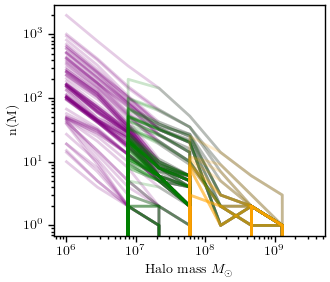

In [29]:
cut_8_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_8.pkl')
cut_7_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_7.pkl')
cut_6_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_6.pkl')

fig = plt.figure(1, figsize=(3.5, 3))
ax = plt.subplot(111)

cut_6_list = []
for realization in cut_6_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_6_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='purple')
cut_7_list = []
for realization in cut_7_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_7_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='green')
cut_8_list = []
for realization in cut_8_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_8_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='orange')

# m_mean = np.mean(cut_6_list, axis=0)
# ax.loglog(m[0:-1], m_mean, color='black', linestyle='--', linewidth=3)

ax.set_xlabel('Halo mass '+r'$M_{\odot}$')
ax.set_ylabel('n(M)')

plt.show()